<a href="https://colab.research.google.com/github/jacobalmon/CS-478/blob/main/Homework/Homework%203/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

In [2]:
# Mounting Google Drive.
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Task 1:
# Load CIFAR-10 Dataset.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize Pixel Values to [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# One-hot Encode the Labels
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
# Task 2: Model Design.
# Load the EfficientNetB0 model with ImageNet weights, excluding the top classification layer.
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the Pretrained Layers.
base_model.trainable = False

# Build Custom Model.
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling layer
    layers.BatchNormalization(),
    layers.Dense(1028, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Custom dense layer.
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))  # Output layer for 10 classes
])

# Compile Model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

# Summary of Model.
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1, 1, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1028)                │       1,316,868 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1028)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,381,849 (20.53 MB)

 Trainable params: 1,329,718 (5.07 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [5]:
# Task 3: Training.
init_history = model.fit(
    x_train, y_train, epochs=5, validation_data=(x_test, y_test)
)

# Unfreeze Pretrained Layers.
base_model.trainable = True

# Compile Model.
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy']
)

# Fine Tune Model.
fine_tune_history = model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test))

# Save Model
model.save('/content/drive/MyDrive/cs478_model_hw3.keras')

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 62s 23ms/step - accuracy: 0.1047 - loss: 10.3850 - val_accuracy: 0.1442 - val_loss: 4.4466
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step - accuracy: 0.1108 - loss: 3.8904 - val_accuracy: 0.1011 - val_loss: 2.7689
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.1136 - loss: 2.6746 - val_accuracy: 0.1345 - val_loss: 2.4184
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.1137 - loss: 2.4131 - val_accuracy: 0.1396 - val_loss: 2.3454
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.1172 - loss: 2.3523 - val_accuracy: 0.1086 - val_loss: 2.3284
Epoch 1/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 144s 46ms/step - accuracy: 0.2164 - loss: 2.2236 - val_accuracy: 0.3663 - val_loss: 1.8344
Epoch 2/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.3867 - loss: 1.7605 - val_accuracy: 0.4520 - val_loss: 1.6069
Epoch 3/15
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - accuracy: 0.4460 - loss: 

In [6]:
model = load_model('/content/drive/MyDrive/cs478_model_hw3.keras')

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.6650 - loss: 1.0483
Test accuracy: 0.6531999707221985


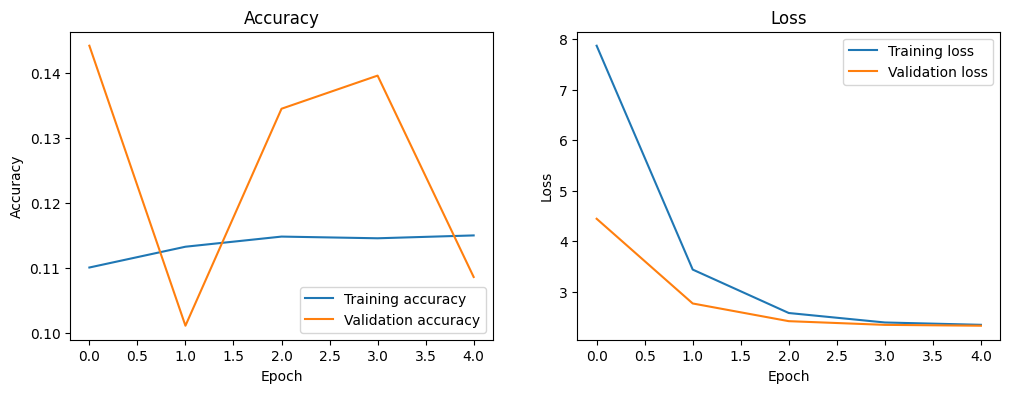

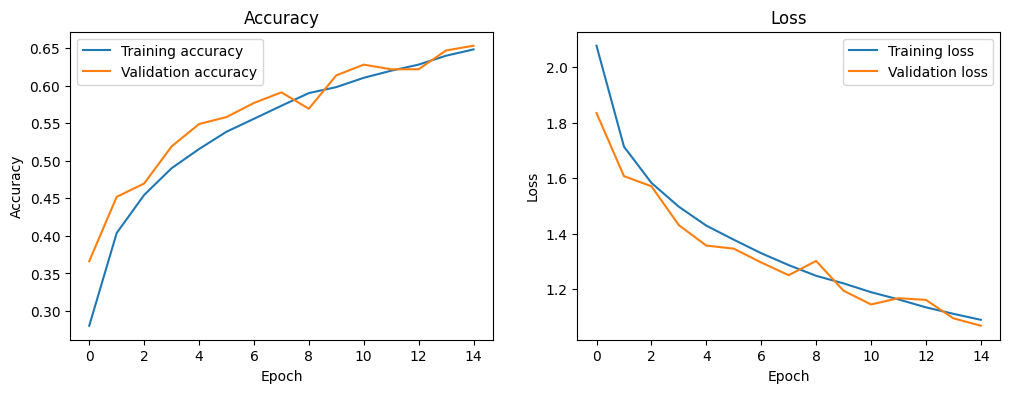

In [7]:
# Task 4: Evaluation.
# Evaluate Model.
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

def plot_history(history):
    # Plot Accuracy.
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss.
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot Results.
plot_history(init_history)
plot_history(fine_tune_history)